In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
%matplotlib inline

names = ['ind', 'ax', 'ay', 'az', 'label']
acc_names = ['ax', 'ay', 'az']
label2str = {1:'Working at Computer', 2:'Standing Up, Walking and Going up-down stairs', 
             3:'Standing', 4:'Walking',5:'Going Up\Down Stairs', 6:'Walking and Talking with Someone', 
             7:'Talking while Standing'}
df = pd.read_csv("Dataset/1.csv", sep=',', names=names)
del df['ind']
df = df[df.label != 0]
df['label_str'] = df.label.apply(lambda x:label2str[x])

# Magnitude
df['mag'] = np.sqrt(np.square(df[acc_names]).sum(axis=1)) 
# Median filter - 3rd ordre
def med_fil(df, names):
    df_r = pd.DataFrame()
    df = df[names]
    for column in df.columns:
        name = column+'_mf'
        df_r[name] = signal.medfilt(df[column].values)
    return df_r
df_med = med_fil(df, acc_names)
# Diffrential
def diffrential(df, names):
    df = df[names]
    df_r = df.diff(periods=1, axis=0).fillna(method='backfill')
    df_r.columns = [names[0]+'_d', names[1]+'_d', names[2]+'_d']
    return df_r
df_diff = diffrential(df, acc_names)
# Low pass filter
def lowpass(df, names):
    df = df[names]
    df_r = pd.DataFrame()
    fs = 52 # frequence sampling is 52
    f_cut = 1 # cutoff frequency
    fs_n = f_cut*2.0/fs # normalized frequency
    b,a = signal.butter(N=3, Wn=fs_n, btype='low')
    for column in df.columns : 
        name = column+'_lp'
        df_r[name] = signal.lfilter(b,a,df[column].values)
    return df_r
df_lp = lowpass(df, acc_names)  
# High pass filter 
def highpass(df, names):
    df = df[names]
    df_r = pd.DataFrame()
    fs = 52 # frequence sampling is 52
    f_cut = 1 # cutoff frequency
    fs_n = f_cut*2.0/fs # normalized frequency
    b,a = signal.butter(N=3, Wn=fs_n, btype='high')
    for column in df.columns : 
        name = column+'_hp'
        df_r[name] = signal.lfilter(b,a,df[column].values)
    return df_r
df_hp = highpass(df, acc_names)

# Total
df = pd.concat([df, df_med, df_diff, df_lp, df_hp], axis=1)
df.head()

,ax,ay,az,label,label_str,mag,ax_mf,ay_mf,az_mf,ax_d,ay_d,az_d,ax_lp,ay_lp,az_lp,ax_hp,ay_hp,az_hp
0,1502,2215,2153,1,Working at Computer,3434.768988,1502,2072,2047,165,-143,-106,0.294570,0.434402,0.422243,1330.950456,1962.753168,1907.813802
1,1667,2072,2047,1,Working at Computer,3355.932359,1611,2072,2047,165,-143,-106,2.023204,2.907854,2.832932,1155.714581,1362.002403,1353.118154
2,1611,1957,1906,1,Working at Computer,3171.435952,1611,1957,1906,-56,-115,-141,7.011663,9.821684,9.584772,789.314495,875.625099,847.401747
3,1601,1939,1831,1,Working at Computer,3110.543843,1611,1957,1879,-10,-18,-75,16.960462,23.217970,22.667546,517.382527,551.056967,481.033069
4,1643,1965,1879,1,Working at Computer,3176.683018,1604,1959,1879,42,26,48,33.066246,44.414894,43.325413,330.972495,313.877533,283.050573


In [2]:
df_KDA = df.copy()
del df_KDA['label_str']

# Within-class scatter matrix
a = df_KDA.groupby('label')
Sw = a.get_group(1).cov()
del Sw['label']
Sw = Sw.drop(['label'])
for i in range(2,len(a)):
    S1 = a.get_group(i).cov()
    S1 = S1.drop(['label'])
    del S1['label']
    Sw = Sw + S1
    
# Between-class scatter matrix
C = 7 # Number of classes
Nf = 16 # Number of features
a = df_KDA.mean(axis=0)
del a['label']
u = a.values
Sb = np.zeros((Nf,Nf))
for i in range(C):
    Ni = df_KDA.groupby('label').count().ax[i+1]
    a = df_KDA.groupby('label').get_group(i+1).mean()
    del a['label']    
    ui = a.values
    x = ui-u
    x = x[:, None]
    Sb += Ni*np.dot(x,x.T)

# Projection Matrix Theta
Proj_dim=3
I = np.linalg.inv(Sw)
lam=np.linalg.eig(I*Sb)[0][0:Proj_dim]
Theta = np.linalg.eig(I*Sb)[1][0:Proj_dim]
label=df_KDA.label
del df_KDA['label']
Y = np.dot(Theta, df_KDA.values.T).T # Projected data

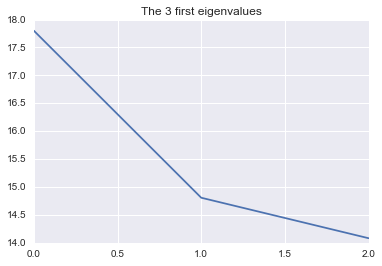

In [3]:
plt.plot(np.log(lam))
plt.title('The '+ str(Proj_dim)+' first eigenvalues')

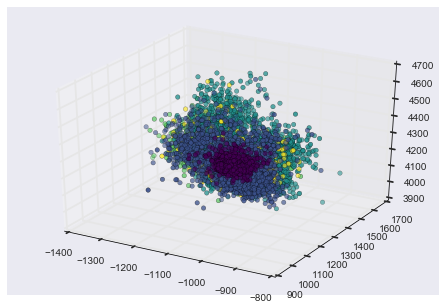

In [85]:
# Display projected data in 3D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Colormap

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Y[64000:80000,0],Y[64000:80000,1], Y[64000:80000,2], c=label[64000:80000], cmap='viridis_r')

In [95]:
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import rbf_kernel
data=df_KDA.values[:][1:1000]
data = normalize(data)
#K = rbf_kernel(data,data,gamma=.3)


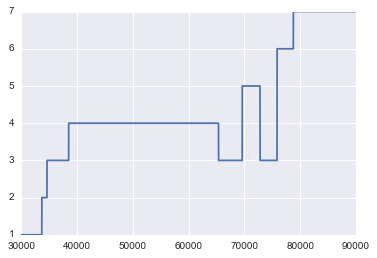

In [40]:
plt.plot(label[30000:90000])

In [81]:
label[30000:90000].values

array([1, 1, 1, ..., 7, 7, 7])

In [55]:
Y.shape

(999, 16)

In [78]:
data.shape

(162500, 16)